<a href="https://colab.research.google.com/github/RaminTKhameneh/ECG/blob/main/ECG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can find the dataset in this link:

http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
import torch.nn.functional as F
from scipy.io import arff

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('drive/MyDrive/695/ECG5000_TRAIN.txt', 'r') as file:
    test = file.read()
    test = test.split('\n')
    test = [row.split() for row in test]
with open('drive/MyDrive/695/ECG5000_TEST.txt', 'r') as file:
    train = file.read()
    train = train.split('\n')
    train = [row.split() for row in train]

In [ ]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
train.drop(index=train.index[-1],axis=0,inplace=True)
test.drop(index=test.index[-1],axis=0,inplace=True)

<ipython-input-6-912129c717e2>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


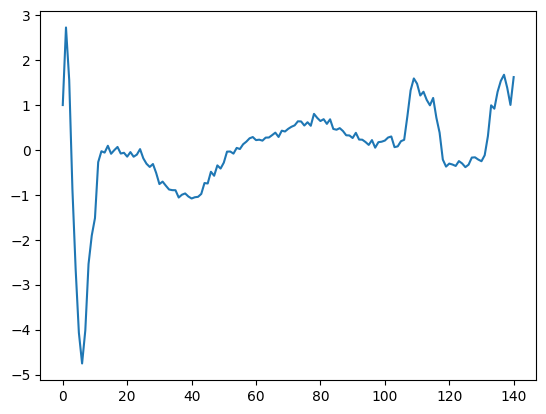

In [ ]:
df = train.append(test)
df = df.astype(float)
aa = np.array(df.loc[1000])
aa.shape
plt.figure()
plt.plot(aa)

In [ ]:
df = train.append(test)
df.shape

<ipython-input-7-f91a550a51fa>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


(5000, 141)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0000000e+00,3.6908442e+00,7.1141435e-01,-2.1140915e+00,-4.1410068e+00,-4.5744716e+00,-3.4319085e+00,-1.9507914e+00,-1.1070667e+00,-6.3232248e-01,...,-3.2476949e-02,2.2846766e-02,1.8893657e-01,4.8093188e-01,6.2925026e-01,5.7729083e-01,6.6552725e-01,1.0359968e+00,1.4922866e+00,-1.9050734e+00
1,1.0000000e+00,-1.3481323e+00,-3.9960376e+00,-4.2267496e+00,-4.2511874e+00,-3.4779528e+00,-2.2284217e+00,-1.8084877e+00,-1.5342415e+00,-7.7986138e-01,...,9.3798389e-01,1.5709378e+00,1.5913944e+00,1.5491932e+00,1.1930770e+00,5.1513440e-01,1.2627351e-01,2.6753217e-01,1.0711484e+00,-1.1640090e+00
2,1.0000000e+00,1.0242946e+00,-5.9031419e-01,-1.9169491e+00,-2.8069890e+00,-3.5279051e+00,-3.6386750e+00,-2.7797674e+00,-2.0190308e+00,-1.9807535e+00,...,3.6882000e-01,4.4350192e-01,8.2758242e-01,1.2370070e+00,1.2351214e+00,1.7381027e+00,1.8007674e+00,1.8163009e+00,1.4739633e+00,1.3897666e+00
3,1.0000000e+00,5.4565692e-01,-1.0143830e+00,-2.3166977e+00,-3.6340397e+00,-4.1968570e+00,-3.7580926e+00,-3.1944444e+00,-2.2217637e+00,-1.5885544e+00,...,8.9463842e-01,7.7752982e-01,1.1192396e+00,9.0298365e-01,5.5409760e-01,4.9705263e-01,4.1811561e-01,7.0310771e-01,1.0646019e+00,-4.4853163e-02
4,1.0000000e+00,6.6113283e-01,-1.5524706e+00,-3.1246406e+00,-4.3133515e+00,-4.0170422e+00,-3.0059934e+00,-1.8324110e+00,-1.5038856e+00,-1.0717055e+00,...,1.4165819e+00,1.2808227e+00,1.4943155e+00,1.6187644e+00,1.4474491e+00,1.2385768e+00,1.7496922e+00,1.9868029e+00,1.4227564e+00,-3.5778384e-01


In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

df = df.reset_index()
del df['index']

In [ ]:
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns

df = df.astype({'target':'float'})

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']
class_names

['Normal', 'R on T', 'PVC', 'SP', 'UB']

In [ ]:
df

,target,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,3.6908442e+00,7.1141435e-01,-2.1140915e+00,-4.1410068e+00,-4.5744716e+00,-3.4319085e+00,-1.9507914e+00,-1.1070667e+00,-6.3232248e-01,...,-3.2476949e-02,2.2846766e-02,1.8893657e-01,4.8093188e-01,6.2925026e-01,5.7729083e-01,6.6552725e-01,1.0359968e+00,1.4922866e+00,-1.9050734e+00
1,1.0,-1.3481323e+00,-3.9960376e+00,-4.2267496e+00,-4.2511874e+00,-3.4779528e+00,-2.2284217e+00,-1.8084877e+00,-1.5342415e+00,-7.7986138e-01,...,9.3798389e-01,1.5709378e+00,1.5913944e+00,1.5491932e+00,1.1930770e+00,5.1513440e-01,1.2627351e-01,2.6753217e-01,1.0711484e+00,-1.1640090e+00
2,1.0,1.0242946e+00,-5.9031419e-01,-1.9169491e+00,-2.8069890e+00,-3.5279051e+00,-3.6386750e+00,-2.7797674e+00,-2.0190308e+00,-1.9807535e+00,...,3.6882000e-01,4.4350192e-01,8.2758242e-01,1.2370070e+00,1.2351214e+00,1.7381027e+00,1.8007674e+00,1.8163009e+00,1.4739633e+00,1.3897666e+00
3,1.0,5.4565692e-01,-1.0143830e+00,-2.3166977e+00,-3.6340397e+00,-4.1968570e+00,-3.7580926e+00,-3.1944444e+00,-2.2217637e+00,-1.5885544e+00,...,8.9463842e-01,7.7752982e-01,1.1192396e+00,9.0298365e-01,5.5409760e-01,4.9705263e-01,4.1811561e-01,7.0310771e-01,1.0646019e+00,-4.4853163e-02
4,1.0,6.6113283e-01,-1.5524706e+00,-3.1246406e+00,-4.3133515e+00,-4.0170422e+00,-3.0059934e+00,-1.8324110e+00,-1.5038856e+00,-1.0717055e+00,...,1.4165819e+00,1.2808227e+00,1.4943155e+00,1.6187644e+00,1.4474491e+00,1.2385768e+00,1.7496922e+00,1.9868029e+00,1.4227564e+00,-3.5778384e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4.0,-4.7857737e-01,-1.7799590e+00,-2.3981589e+00,-3.1701118e+00,-3.5597319e+00,-3.5739558e+00,-2.9897701e+00,-2.2706046e+00,-1.6882766e+00,...,1.2948401e+00,1.1608845e+00,1.4563312e+00,2.2094208e+00,2.5071751e+00,2.1985340e+00,1.7058490e+00,1.4926416e+00,1.5618897e+00,1.5201610e+00
4996,4.0,-1.3252098e+00,-2.4809922e+00,-2.9653559e+00,-3.3423924e+00,-3.1763512e+00,-2.8915279e+00,-2.3696788e+00,-1.5987502e+00,-1.0717507e+00,...,5.5207606e-01,-1.7215403e-01,-8.6480326e-01,-1.5498538e+00,-2.4602433e+00,-3.3665622e+00,-3.4665462e+00,-2.7183804e+00,-1.8552087e+00,-1.5399579e+00
4997,4.0,-2.1963843e-02,-9.1243389e-01,-1.9033529e+00,-2.6628290e+00,-3.1221560e+00,-3.4514903e+00,-3.3929816e+00,-2.9299374e+00,-2.2562941e+00,...,1.5287446e+00,1.3394788e+00,1.4579951e+00,2.1280785e+00,2.6307589e+00,2.2957478e+00,1.7649670e+00,1.4442803e+00,1.4323469e+00,1.4570283e+00
4998,5.0,2.8801100e-01,-1.0980196e+00,-2.5002499e+00,-3.5985989e+00,-3.6506084e+00,-3.2815873e+00,-2.2316013e+00,-1.2506564e+00,-1.0725741e+00,...,8.1634188e-02,-2.9242159e-02,7.1414393e-02,1.1816081e-01,-7.1966657e-02,-1.7121424e-01,1.3121145e-01,4.9872417e-02,1.0914960e-02,-8.1534236e-02


In [ ]:
df.target.value_counts()


1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: target, dtype: int64

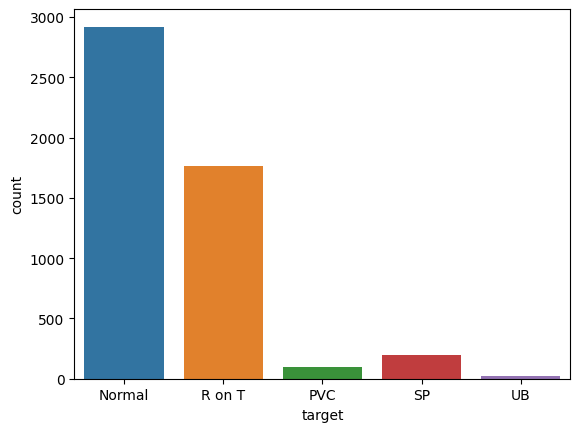

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='target', data=df, ax=ax)

ax.set_xticklabels(['Normal', 'R on T', 'PVC', 'SP', 'UB'])

plt.show()

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

0 1.0
1 2.0
2 3.0
3 4.0
4 5.0


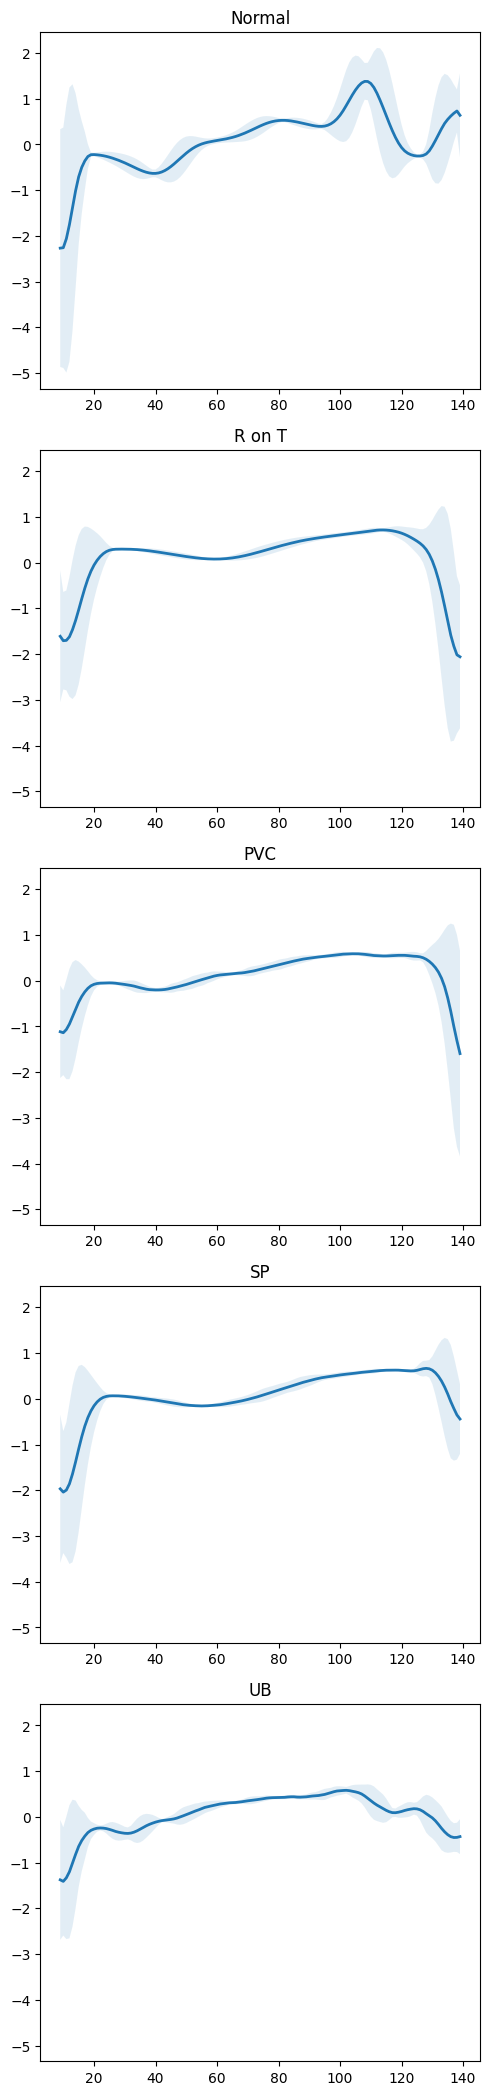

In [ ]:
df = df.astype(float)

classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 1 + 1,
    ncols=1,
    sharey=True,
    figsize=(5, 25)
    )

for i, cls in enumerate(classes):
    print(i,cls)
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean().to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [ ]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [ ]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [ ]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

RNN

In [ ]:
normal_df,train_df,val_df, test_df

(           1         2         3         4         5         6         7    \
 0     3.690844  0.711414 -2.114091 -4.141007 -4.574472 -3.431909 -1.950791   
 1    -1.348132 -3.996038 -4.226750 -4.251187 -3.477953 -2.228422 -1.808488   
 2     1.024295 -0.590314 -1.916949 -2.806989 -3.527905 -3.638675 -2.779767   
 3     0.545657 -1.014383 -2.316698 -3.634040 -4.196857 -3.758093 -3.194444   
 4     0.661133 -1.552471 -3.124641 -4.313351 -4.017042 -3.005993 -1.832411   
 ...        ...       ...       ...       ...       ...       ...       ...   
 4787  1.513542  1.703299  0.105858 -1.734316 -2.923845 -3.960274 -3.548093   
 4788 -0.350679 -1.797723 -3.382608 -4.584815 -4.398598 -3.582011 -2.506601   
 4789 -2.652819 -3.706776 -3.977027 -3.767593 -3.193039 -2.351071 -1.261787   
 4790  1.663198 -0.081416 -1.973330 -3.209562 -4.202891 -3.835213 -2.626553   
 4791  1.510468 -0.267296 -2.225970 -3.350706 -4.310554 -3.906900 -2.596504   
 
            8         9         10   ...       131

In [ ]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))


In [ ]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 64.11883444903312 val loss 55.35775838858439
Epoch 2: train loss 53.618953229726586 val loss 50.287631155280934
Epoch 3: train loss 53.43524992595705 val loss 50.04342206102182
Epoch 4: train loss 46.21430890553423 val loss 38.16060160614118
Epoch 5: train loss 33.45790259773719 val loss 31.20287309653116
Epoch 6: train loss 30.820928791558153 val loss 29.472007207903033
Epoch 7: train loss 28.52820040707817 val loss 28.770547837527538
Epoch 8: train loss 27.17087742476058 val loss 30.967721525719547
Epoch 9: train loss 27.19333217087315 val loss 30.42231503118834
Epoch 10: train loss 26.529249769024002 val loss 24.221384868686922
Epoch 11: train loss 26.013434430467942 val loss 23.2650809239202
Epoch 12: train loss 24.541277043620504 val loss 23.399098715277663
Epoch 13: train loss 23.821096780846936 val loss 21.05525252111129
Epoch 14: train loss 23.14337341788314 val loss 23.195327420283505
Epoch 15: train loss 21.083115316696198 val loss 18.599077084772414
Epoch

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

<ipython-input-31-b1e9518eed74>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


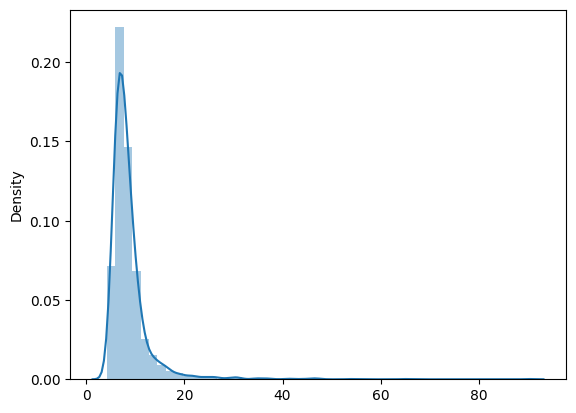

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 26

<ipython-input-33-ed53989f8e41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


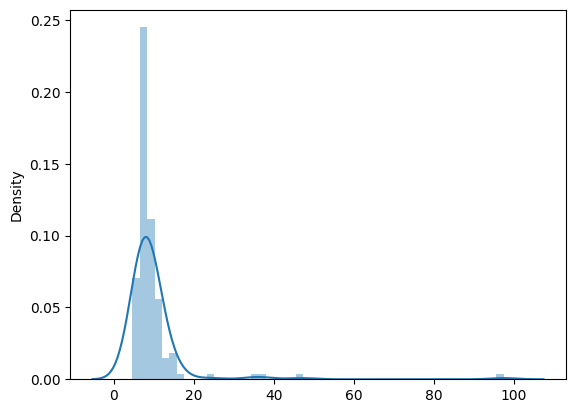

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 141/145


In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-36-ad94685d44b0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


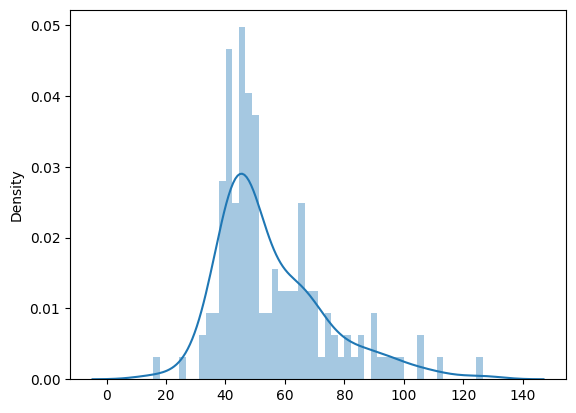

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 143/145


In [ ]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


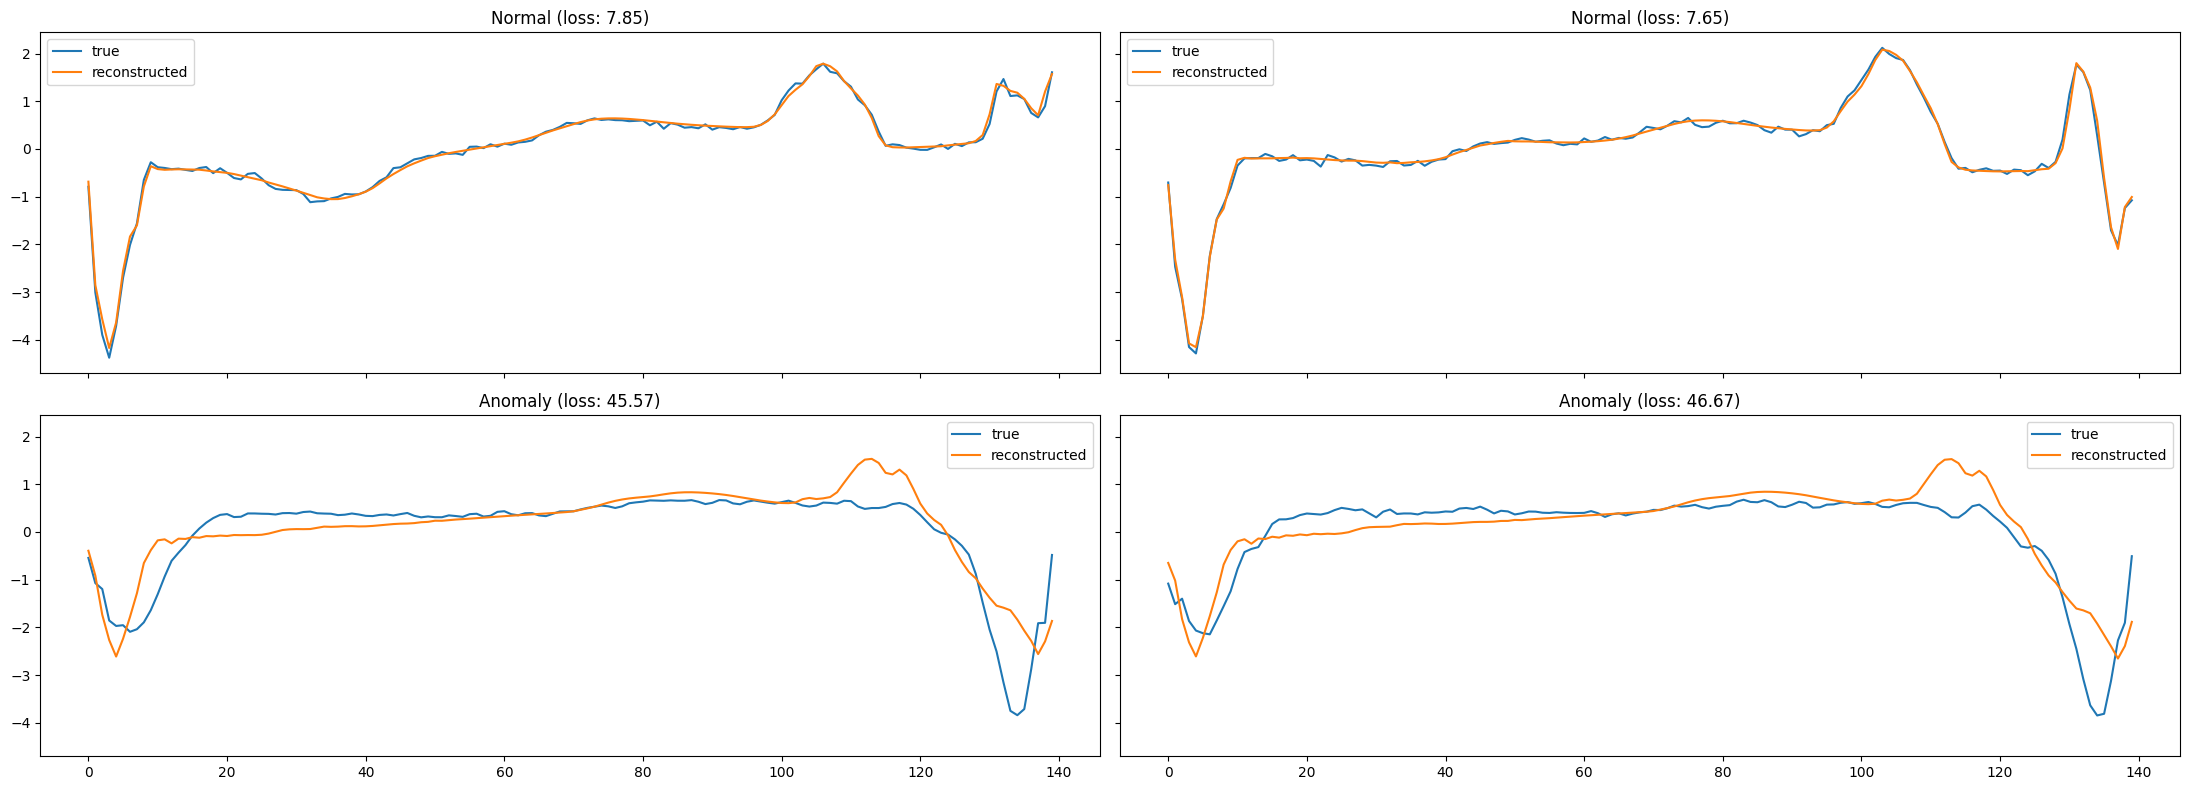

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:2]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:2]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

SVM

In [ ]:
X = df.drop(labels='target', axis=1)
y = df['target'].apply(lambda x: 1 if x == 1 else 0) # label normal as 1 and abnormal as 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED) # 0.25 x 0.8 = 0.2

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
svm_classifier = SVC(kernel='rbf', random_state=RANDOM_SEED)
svm_classifier.fit(X_train, y_train)

y_val_pred = svm_classifier.predict(X_val)
y_test_pred = svm_classifier.predict(X_test)

In [ ]:
counter0 = 0
counter1 = 0

for i in range(len(y_test_pred)):
  if y_test_pred[i] == 0 and y_test.iloc[i] == 0:
    counter0+=1
  if y_test_pred[i] == 1 and y_test.iloc[i] == 1:
    counter1+=1

In [ ]:
counter0,counter1, sum(y_test),len(y_test) - sum(y_test)

(409, 581, 586, 414)

In [ ]:
y_val_pred = svm_classifier.predict(X_val)
y_test_pred = svm_classifier.predict(X_test)

mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Validation MAE: {mae_val:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Validation MAE: 0.0110
Test MAE: 0.0100


random forrest

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.992
Precision: 0.9881756756756757
Recall: 0.9982935153583617
F1 Score: 0.9932088285229201
Confusion Matrix:
 [[407   7]
 [  1 585]]
